In [1]:
# JSH: Comments on text.
# 1. The main point of this tutorial is to show how JAX AD can be used to
#    take away a lot of the by-hand differentiation. When I read this
#    intro, it just seems like something I could have done in e.g. MFront.
# 2. The equations should be put down where you define them in the code.

# Plasticity of Mohr-Coulomb

The current tutorial implements the non-associative plasticity model of
Mohr-Coulomb with apex-smoothing, where the constitutive relations are defined
using the external package JAX. Here we consider the same cylinder expansion
problem in the two-dimensional case in a symmetric formulation, which was
considered in the previous tutorial on von Mises plasticity.

The tutorial is based on the MFront/TFEL
[implementation](https://thelfer.github.io/tfel/web/MohrCoulomb.html) of the
Mohr-Coulomb elastoplastic model with apex smoothing.

## Problem formulation

We solve the same cylinder expansion problem from the previous tutorial of
von Mises plasticity and follow the same Mandel-Voigt notation. Thus, we
focus here on the constitutive model definition and its implementation.

We consider a non-associative plasticity law without hardening that is
defined by the Mohr-Coulomb yield surface $F$ and the plastic potential $G$.
Both quantities may be expressed through the following function $H$

\begin{align*}
    & H(\boldsymbol{\sigma}, \alpha) =
    \frac{I_1(\boldsymbol{\sigma})}{3}\sin\alpha +
    \sqrt{J_2(\boldsymbol{\sigma}) K^2(\alpha) + a^2(\alpha)\sin^2\alpha} -
    c\cos\alpha, \\
    & F(\boldsymbol{\sigma}) = H(\boldsymbol{\sigma}, \phi), \\
    & G(\boldsymbol{\sigma}) = H(\boldsymbol{\sigma}, \psi),
\end{align*}
where $\phi$ and $\psi$ are friction and dilatancy angles, $c$ is a cohesion,
$I_1(\boldsymbol{\sigma}) = \mathrm{tr} \boldsymbol{\sigma}$ is the first
invariant of the stress tensor and $J_2(\boldsymbol{\sigma}) =
\frac{1}{2}\boldsymbol{s}:\boldsymbol{s}$ is the second invariant of the
deviatoric part of the stress tensor. The expression of the coefficient
$K(\alpha)$ may be found in the MFront/TFEL
[implementation](https://thelfer.github.io/tfel/web/MohrCoulomb.html).

During the plastic loading the stress-strain state of the solid must satisfy
the following system of nonlinear equations

$$
    \begin{cases}
        \boldsymbol{r}_{G}(\boldsymbol{\sigma}_{n+1}, \Delta\lambda) =
        \boldsymbol{\sigma}_{n+1} - \boldsymbol{\sigma}_n -
        \boldsymbol{C}.(\Delta\boldsymbol{\varepsilon} - \Delta\lambda
        \frac{d G}{d\boldsymbol{\sigma}}(\boldsymbol{\sigma_{n+1}})) =
        \boldsymbol{0}, \\
        r_F(\boldsymbol{\sigma}_{n+1}) = F(\boldsymbol{\sigma}_{n+1}) = 0,
    \end{cases}
$$ (eq_MC_1)

By introducing the residual vector $\boldsymbol{r} = [\boldsymbol{r}_{G}^T,
r_F]^T$ and its argument vector $\boldsymbol{x} = [\sigma_{xx}, \sigma_{yy},
\sigma_{zz}, \sqrt{2}\sigma_{xy}, \Delta\lambda]^T$ we solve the following
equation:

$$
    \boldsymbol{r}(\boldsymbol{x}_{n+1}) = \boldsymbol{0}
$$

To solve this system we apply the Newton method and then introduce the
Jacobian of the residual vector $\boldsymbol{j} = \frac{\partial
\boldsymbol{r}}{\partial \boldsymbol{x}}$

$$
    \boldsymbol{r}(\boldsymbol{x}_{n+1}) = \boldsymbol{r}(\boldsymbol{x}_{n})
    + \boldsymbol{j}(\boldsymbol{x}_{n})(\boldsymbol{x}_{n+1} -
    \boldsymbol{x}_{n})
$$

$$
    \boldsymbol{j}(\boldsymbol{x}_{n})\boldsymbol{y} = -
    \boldsymbol{r}(\boldsymbol{x}_{n})
$$

$$ \boldsymbol{r}(\boldsymbol{x}_{n+1}) = \boldsymbol{r}(\boldsymbol{x}_{n}) +
\boldsymbol{j}(\boldsymbol{x}_{n})(\boldsymbol{x}_{n+1} - \boldsymbol{x}_{n}) $$

$$ \boldsymbol{j}(\boldsymbol{x}_{n})\boldsymbol{y} = -
\boldsymbol{r}(\boldsymbol{x}_{n}) $$

$$ \boldsymbol{x}_{n+1} = \boldsymbol{x}_n + \boldsymbol{y} $$

During the elastic loading, we consider a trivial system of equations

$$
    \begin{cases}
        \boldsymbol{\sigma}_{n+1} = \boldsymbol{\sigma}_n +
        \boldsymbol{C}.\Delta\boldsymbol{\varepsilon}, \\ \Delta\lambda = 0.
    \end{cases}
$$ (eq_MC_2)

The algorithm solving the systems {eq}`eq_MC_1`--{eq}`eq_MC_2` is called the
return-mapping procedure and the solution defines the return-mapping
correction of the stress tensor. By implementation of the external operator
$\boldsymbol{\sigma}$ we mean the implementation of the return-mapping
procedure. By applying the automatic differentiation (AD) technique to this
algorithm we may restore the stress derivative
$\frac{\mathrm{d}\boldsymbol{\sigma}}{\mathrm{d}\boldsymbol{\varepsilon}}$.

The JAX library was used to implement the external operator and its
derivative.

```{note}
Although the tutorial shows the implementation of the Mohr-Coulomb model, it
is quite general to be adapted to a wide rage of plasticity models that may
be defined through a yield surface and a plastic potential.
```

## Implementation

### Preamble

In [2]:
from mpi4py import MPI
from petsc4py import PETSc

import jax
import jax.lax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from solvers import LinearProblem
from utilities import build_cylinder_quarter, find_cell_by_point

import basix
import ufl
from dolfinx import common, fem
from dolfinx_external_operator import (
    FEMExternalOperator,
    evaluate_external_operators,
    evaluate_operands,
    replace_external_operators,
)

jax.config.update("jax_enable_x64", True)  # replace by JAX_ENABLE_X64=True

### Model parameters

Here we define geometrical and material parameters of the problem as well as
some useful constants.

In [3]:
R_i = 1  # [m] Inner radius
R_e = 21  # [m] Outer radius

E = 6778  # [MPa] Young modulus
nu = 0.25  # [-] Poisson ratio
P_i_value = 3.45  # [MPa]

c = 3.45  # [MPa] cohesion
phi = 30 * np.pi / 180  # [rad] friction angle
psi = 30 * np.pi / 180  # [rad] dilatancy angle
theta_T = 20 * np.pi / 180  # [rad] transition angle as defined by Abbo and Sloan
a = 0.5 * c / np.tan(phi)  # [MPa] tension cuff-off parameter

In [4]:
mesh, facet_tags, facet_tags_labels = build_cylinder_quarter(R_e=R_e, R_i=R_i)

In [5]:
k_u = 2
V = fem.functionspace(mesh, ("Lagrange", k_u, (2,)))
# Boundary conditions
bottom_facets = facet_tags.find(facet_tags_labels["Lx"])
left_facets = facet_tags.find(facet_tags_labels["Ly"])

bottom_dofs_y = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim - 1, bottom_facets)
left_dofs_x = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim - 1, left_facets)

sym_bottom = fem.dirichletbc(np.array(0.0, dtype=PETSc.ScalarType), bottom_dofs_y, V.sub(1))
sym_left = fem.dirichletbc(np.array(0.0, dtype=PETSc.ScalarType), left_dofs_x, V.sub(0))

bcs = [sym_bottom, sym_left]


def epsilon(v):
    grad_v = ufl.grad(v)
    return ufl.as_vector([grad_v[0, 0], grad_v[1, 1], 0, np.sqrt(2.0) * 0.5 * (grad_v[0, 1] + grad_v[1, 0])])


k_stress = 2 * (k_u - 1)
ds = ufl.Measure(
    "ds",
    domain=mesh,
    subdomain_data=facet_tags,
    metadata={"quadrature_degree": k_stress, "quadrature_scheme": "default"},
)

dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": k_stress, "quadrature_scheme": "default"},
)

S_element = basix.ufl.quadrature_element(mesh.topology.cell_name(), degree=k_stress, value_shape=(4,))
S = fem.functionspace(mesh, S_element)


Du = fem.Function(V, name="displacement_increment")
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="du")
v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

sigma = FEMExternalOperator(epsilon(Du), function_space=S)
sigma_n = fem.Function(S, name="sigma_n")

### Defining the external operator

In order to define the behaviour of the external operator and its
derivatives, we need to implement the return-mapping procedure solving the
constitutive equations {eq}`eq_MC_1`--{eq}`eq_MC_2` and apply the automatic
differentiation tool to this algorithm.

#### Defining yield surface and plastic potential

First of all, we define supplementary functions that help us to express the
yield surface $F$ and the plastic potential $G$. In the following definitions,
we use built-in functions of the JAX package, in particular, the conditional
primitive `jax.lax.cond`. It is necessary for the correct work of the AD tool
and just-in-time compilation. For more details, please, visit the JAX
[documentation](https://jax.readthedocs.io/en/latest/).

In [6]:
def J3(sigma_local):
    return sigma_local[2] * (sigma_local[0] * sigma_local[1] - sigma_local[3] * sigma_local[3] / 2.0)


def coeff1(theta, angle):
    return jnp.cos(theta_T) - (1.0 / (jnp.sqrt(3.0)) * jnp.sin(angle) * jnp.sign(theta) * jnp.sin(theta_T))


def coeff2(theta, angle):
    return jnp.sign(theta) * jnp.sin(theta_T) + (1.0 / (jnp.sqrt(3.0)) * jnp.sin(angle) * jnp.cos(theta_T))


# JSH: use float literals where you want floats.
coeff3 = 18.0 * jnp.cos(3.0 * theta_T) * jnp.cos(3.0 * theta_T) * jnp.cos(3.0 * theta_T)


def C(theta, angle):
    return (
        -jnp.cos(3.0 * theta_T) * coeff1(theta, angle)
        - 3.0 * jnp.sign(theta) * jnp.sin(3.0 * theta_T) * coeff2(theta, angle)
    ) / coeff3


def B(theta, angle):
    return (
        jnp.sign(theta) * jnp.sin(6.0 * theta_T) * coeff1(theta, angle)
        - 6.0 * jnp.cos(6.0 * theta_T) * coeff2(theta, angle)
    ) / coeff3


def A(theta, angle):
    return (
        -(1.0 / jnp.sqrt(3.0)) * jnp.sin(angle) * jnp.sign(theta) * jnp.sin(theta_T)
        - B(theta, angle) * jnp.sign(theta) * jnp.sin(theta_T)
        - C(theta, angle) * jnp.sin(3.0 * theta_T) * jnp.sin(3.0 * theta_T)
        + jnp.cos(theta_T)
    )


def K(theta, angle):
    def K_true(theta, angle):
        return jnp.cos(theta) - (1.0 / jnp.sqrt(3.0)) * jnp.sin(angle) * jnp.sin(theta)

    def K_false(theta, angle):
        return (
            A(theta, angle)
            + B(theta, angle) * jnp.sin(3.0 * theta)
            + C(theta, angle) * jnp.sin(3.0 * theta) * jnp.sin(3.0 * theta)
        )

    return jax.lax.cond(jnp.abs(theta) < theta_T, K_true, K_false, theta, angle)


def a_G(angle):
    return a * jnp.tan(phi) / jnp.tan(angle)

dev = jnp.array(
        [
            [2.0 / 3.0, -1.0 / 3.0, -1.0 / 3.0, 0.0],
            [-1.0 / 3.0, 2.0 / 3.0, -1.0 / 3.0, 0.0],
            [-1.0 / 3.0, -1.0 / 3.0, 2.0 / 3.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        dtype=PETSc.ScalarType,
    )
def surface(sigma_local, angle):
    # AL: Maybe it's more efficient to use untracable np.array?
    dev = jnp.array(
        [
            [2.0 / 3.0, -1.0 / 3.0, -1.0 / 3.0, 0.0],
            [-1.0 / 3.0, 2.0 / 3.0, -1.0 / 3.0, 0.0],
            [-1.0 / 3.0, -1.0 / 3.0, 2.0 / 3.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        dtype=PETSc.ScalarType,
    )

    s = dev @ sigma_local

    tr = jnp.array([1.0, 1.0, 1.0, 0.0], dtype=PETSc.ScalarType)
    I1 = tr @ sigma_local

    J2 = 0.5 * jnp.vdot(s, s)

    arg = -(3.0 * jnp.sqrt(3.0) * J3(s)) / (2.0 * jnp.sqrt(J2 * J2 * J2))
    arg = jnp.clip(arg, -1.0, 1.0)

    theta = 1.0 / 3.0 * jnp.arcsin(arg)
    return (
        (I1 / 3.0 * jnp.sin(angle))
        + jnp.sqrt(J2 * K(theta, angle) * K(theta, angle) + a_G(angle) * a_G(angle) * jnp.sin(angle) * jnp.sin(angle))
        - c * jnp.cos(angle)
    )

By picking up an appropriate angle we define the yield surface $F$ and the
plastic potential $G$.

In [7]:
# JSH: Does this trace phi and psi as static constants?
def f_MC(sigma_local):
    # return surface(sigma_local, phi)
    s = dev @ sigma_local
    J2 = 0.5 * jnp.vdot(s, s)
    return jnp.sqrt(3*J2) #von Mises


def g_MC(sigma_local):
    return surface(sigma_local, psi)


# JSH: Isn't argnums the default?
dgdsigma = jax.jacfwd(g_MC, argnums=(0))

#### Some tests

In [8]:
def f_MC_to_plot(sigma_I, sigma_II, sigma_III):
    sigma_local = jnp.array([sigma_I, sigma_II, sigma_III, 0])
    return f_MC(sigma_local)

f_MC_to_plot_vec = jax.vmap(f_MC_to_plot)

In [9]:
sigma_I = sigma_II = np.array([1., 2.0])
sigma_III = np.array([0.0, 0.0])
f_MC_to_plot_vec(sigma_I, sigma_II, sigma_III)

Array([1., 2.], dtype=float64)

In [10]:
sigma_I = sigma_II = np.arange(1.0, 3.0, 0.05)
X, Y = np.meshgrid(sigma_I, sigma_II)
sigma_III = np.zeros_like(X)

In [11]:
Z = f_MC_to_plot_vec(X.reshape(-1), Y.reshape(-1), sigma_III.reshape(-1)).reshape(X.shape)

In [12]:
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.set_zlim(-1, 1)
ax.plot_surface(X, Y, Z)

<Figure size 640x480 with 0 Axes>

In [13]:
sigma_local = jnp.array([0.00001, 0.00001, 0.0, 0.0])
f_MC(sigma_local)

Array(1.e-05, dtype=float64)

In [14]:
def von_mises(sigma_I, sigma_II, sigma_III):
    sigma_local = jnp.array([sigma_I, sigma_II, sigma_III, 0])
    dev = jnp.array(
        [
            [2.0 / 3.0, -1.0 / 3.0, -1.0 / 3.0, 0.0],
            [-1.0 / 3.0, 2.0 / 3.0, -1.0 / 3.0, 0.0],
            [-1.0 / 3.0, -1.0 / 3.0, 2.0 / 3.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ],
        dtype=PETSc.ScalarType,
    )
    s = dev @ sigma_local

    return jnp.sqrt(3*0.5 * jnp.vdot(s, s))

von_mises_vec = jax.vmap(von_mises)

In [15]:
one = np.ones(100)
R = 5.
u = np.linspace(0, np.pi/2, 100)
x = R * np.outer(np.cos(u), one)
y = R * np.outer(np.sin(u), one)
z = np.outer(np.linspace(0.5, 10, 100), one)

In [16]:
R = 5.
height = 10
resolution = 100
theta = np.linspace(0, 2*np.pi, resolution)
z = np.linspace(0.1, height, resolution)
theta, z = np.meshgrid(theta, z)
x = R * np.cos(theta)
y = R * np.sin(theta)
# x = R * z/height * np.cos(theta)
# y = R * z/height * np.sin(theta)

In [17]:
F = f_MC_to_plot_vec(x.reshape(-1), y.reshape(-1), z.reshape(-1)).reshape(x.shape)
F = von_mises_vec(x.reshape(-1), y.reshape(-1), z.reshape(-1)).reshape(x.shape)

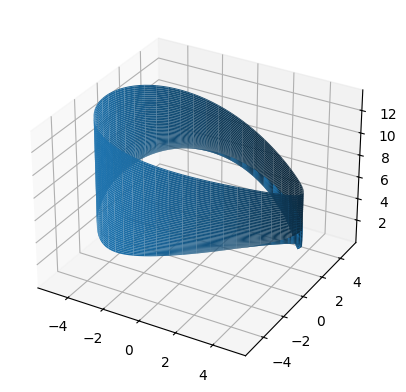

In [18]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, F)

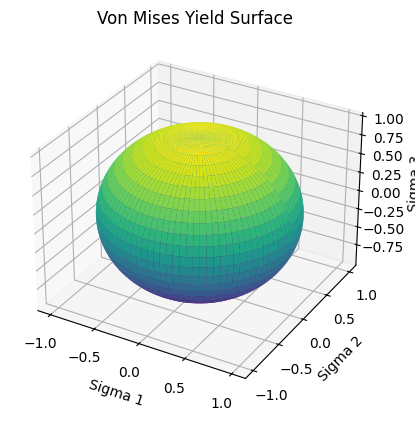

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate data points for the von Mises yield surface
theta = np.linspace(0, 2 * np.pi, 100)
phi = np.linspace(0, np.pi, 100)
theta, phi = np.meshgrid(theta, phi)
sigma_1 = np.sin(theta) * np.cos(phi)
sigma_2 = np.sin(theta) * np.sin(phi)
sigma_3 = np.cos(theta)
von_mises = np.sqrt(sigma_1**2 + sigma_2**2 + sigma_3**2 - sigma_1*sigma_2 - sigma_2*sigma_3 - sigma_3*sigma_1)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the von Mises yield surface
ax.plot_surface(sigma_1, sigma_2, sigma_3, cmap='viridis', edgecolor='none')

# Set labels and title
ax.set_xlabel('Sigma 1')
ax.set_ylabel('Sigma 2')
ax.set_zlabel('Sigma 3')
ax.set_title('Von Mises Yield Surface')

# Show the plot
plt.show()


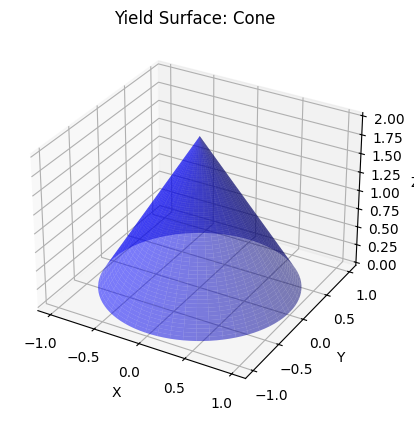

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters for the cone
radius = 1
height = 2
resolution = 100

# Generate data points for the surface of the cone
theta = np.linspace(0, 2*np.pi, resolution)
z = np.linspace(0, height, resolution)
theta, z = np.meshgrid(theta, z)
x = radius * (1 - z/height) * np.cos(theta)
y = radius * (1 - z/height) * np.sin(theta)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface of the cone
ax.plot_surface(x, y, z, color='b', alpha=0.5)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Yield Surface: Cone')

# Show the plot
plt.show()


In [21]:
z.shape

(100, 100)

In [22]:
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
v = np.full((100), np.pi/2)
x = np.outer(np.cos(u), np.sin(v))
x

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99798668, 0.99798668, 0.99798668, ..., 0.99798668, 0.99798668,
        0.99798668],
       [0.99195481, 0.99195481, 0.99195481, ..., 0.99195481, 0.99195481,
        0.99195481],
       ...,
       [0.99195481, 0.99195481, 0.99195481, ..., 0.99195481, 0.99195481,
        0.99195481],
       [0.99798668, 0.99798668, 0.99798668, ..., 0.99798668, 0.99798668,
        0.99798668],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

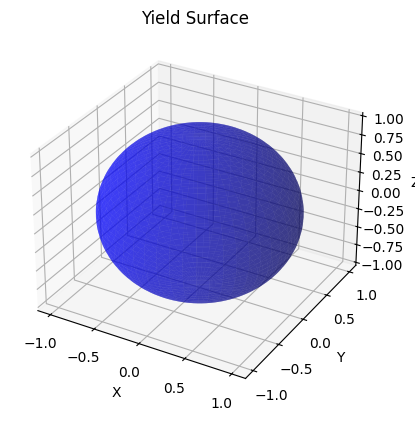

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate data points for a sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the sphere
ax.plot_surface(x, y, z, color='b', alpha=0.5)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Yield Surface')

# Show the plot
plt.show()


#### Solving constitutive equations

In this section, we define the constitutive model by solving the following
systems

\begin{align*}
    & \text{Plastic flow:} \\
    & \begin{cases}
        \boldsymbol{r}_{G}(\boldsymbol{\sigma}_{n+1}, \Delta\lambda) =
        \boldsymbol{\sigma}_{n+1} - \boldsymbol{\sigma}_n -
        \boldsymbol{C}.(\Delta\boldsymbol{\varepsilon} - \Delta\lambda
        \frac{d G}{d\boldsymbol{\sigma}}(\boldsymbol{\sigma_{n+1}})) =
        \boldsymbol{0}, \\
        r_F(\boldsymbol{\sigma}_{n+1}) = F(\boldsymbol{\sigma}_{n+1}) = 0,
     \end{cases} \\
    & \text{Elastic flow:} \\
    &\begin{cases}
        \boldsymbol{\sigma}_{n+1} = \boldsymbol{\sigma}_n +
        \boldsymbol{C}.\Delta\boldsymbol{\varepsilon}, \\ \Delta\lambda = 0.
    \end{cases}
\end{align*}

As the second one is trivial we focus on the first system only and rewrite it
in the following form.

$$
    \boldsymbol{r}(\boldsymbol{x}_{n+1}) = \boldsymbol{0},
$$

where $\boldsymbol{x} = [\sigma_{xx}, \sigma_{yy}, \sigma_{zz},
\sqrt{2}\sigma_{xy}, \Delta\lambda]^T$.

This nonlinear equation must be solved at each Gauss point, so we apply the
Newton method, implement the whole algorithm locally and then vectorize the
final result using `jax.vmap`.

In the following cell, we define locally the residual $\boldsymbol{r}$ and
its jacobian $\boldsymbol{j}$.

In [8]:
phi = 30 * np.pi / 180  # [rad] friction angle

In [9]:
# NOTE: Actually, I put conditionals inside local functions, but we may
# implement two "branches" of the algo separetly and check the yielding
# condition in the main Newton loop. It may be more efficient, but idk. Anyway,
# as it is, it looks fancier.

lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))
C_elas = np.array(
    [
        [lmbda + 2.0 * mu, lmbda, lmbda, 0.0],
        [lmbda, lmbda + 2.0 * mu, lmbda, 0.0],
        [lmbda, lmbda, lmbda + 2.0 * mu, 0.0],
        [0.0, 0.0, 0.0, 2.0 * mu],
    ],
    dtype=PETSc.ScalarType,
)


def deps_p(sigma_local, dlambda, deps_local, sigma_n_local):
    sigma_elas_local = sigma_n_local + C_elas @ deps_local
    # print(sigma_elas_local.shape)
    yielding = f_MC(sigma_elas_local)
    print(yielding)

    def deps_p_elastic(sigma_local, dlambda):
        return jnp.zeros(4, dtype=PETSc.ScalarType)

    def deps_p_plastic(sigma_local, dlambda):
        # print('flag')
        return dlambda * dgdsigma(sigma_local)

    return jax.lax.cond(yielding <= 0.0, deps_p_elastic, deps_p_plastic, sigma_local, dlambda)


def r_sigma(sigma_local, dlambda, deps_local, sigma_n_local):
    deps_p_local = deps_p(sigma_local, dlambda, deps_local, sigma_n_local)
    return sigma_local - sigma_n_local - C_elas @ (deps_local - deps_p_local)


def r_f(sigma_local, dlambda, deps_local, sigma_n_local):
    sigma_elas_local = sigma_n_local + C_elas @ deps_local
    yielding = f_MC(sigma_elas_local)

    def r_f_elastic(sigma_local, dlambda):
        return dlambda

    def r_f_plastic(sigma_local, dlambda):
        return f_MC(sigma_local)

    # JSH: Why is this comparison with eps? eps is essentially 0.0 when doing
    # <=. AL: In the case of yielding = 1e-15 - 1e-16 (or we can choose the
    # tolerance), the plastic branch will be chosen, which is more expensive.
    return jax.lax.cond(yielding <= 0.0, r_f_elastic, r_f_plastic, sigma_local, dlambda)


def r(x_local, deps_local, sigma_n_local):
    sigma_local = x_local[:4]
    dlambda_local = x_local[-1]

    res_sigma = r_sigma(sigma_local, dlambda_local, deps_local, sigma_n_local)
    res_f = r_f(sigma_local, dlambda_local, deps_local, sigma_n_local)

    res = jnp.c_["0,1,-1", res_sigma, res_f]
    return res


drdx = jax.jacfwd(r)

Then we define the function `return_mapping` that implements the
return-mapping algorithm numerically via the Newton method.

In [10]:
Nitermax, tol = 200, 1e-8


# JSH: You need to explain somewhere here how the while_loop interacts with
# vmap.
def sigma_return_mapping(deps_local, sigma_n_local):
    """Performs the return-mapping procedure.

    It solves elastoplastic constitutive equations numerically by applying the
    Newton method in a single Gauss point. The Newton loop is implement via
    `jax.lax.while_loop`.
    """
    niter = 0

    dlambda = jnp.array([0.0])
    sigma_local = sigma_n_local
    x_local = jnp.concatenate([sigma_local, dlambda])

    res = r(x_local, deps_local, sigma_n_local)
    norm_res0 = jnp.linalg.norm(res)

    def cond_fun(state):
        norm_res, niter, _ = state
        return jnp.logical_and(norm_res / norm_res0 > tol, niter < Nitermax)

    def body_fun(state):
        norm_res, niter, history = state

        x_local, deps_local, sigma_n_local, res = history

        J = drdx(x_local, deps_local, sigma_n_local)
        j_inv_vp = jnp.linalg.solve(J, -res)
        x_local = x_local + j_inv_vp

        res = r(x_local, deps_local, sigma_n_local)
        norm_res = jnp.linalg.norm(res)
        history = x_local, deps_local, sigma_n_local, res

        niter += 1

        return (norm_res, niter, history)

    history = (x_local, deps_local, sigma_n_local, res)

    norm_res, niter_total, x_local = jax.lax.while_loop(cond_fun, body_fun, (norm_res0, niter, history))

    sigma_local = x_local[0][:4]
    sigma_elas_local = C_elas @ deps_local
    yielding = f_MC(sigma_n_local + sigma_elas_local)

    return sigma_local, (sigma_local, niter_total, yielding, norm_res)
    # return sigma_local, (sigma_local,)

In [11]:
S_elas = np.linalg.inv(C_elas)

In [12]:
def J2(s):
    return 0.5 * jnp.vdot(s, s)

def rho(sigma_local):
    s = dev @ sigma_local
    return jnp.sqrt(2.0 * J2(s))

def angle(sigma_local):
    s = dev @ sigma_local
    arg = -(3.0 * jnp.sqrt(3.0) * J3(s)) / (2.0 * jnp.sqrt(J2(s) * J2(s) * J2(s)))
    arg = jnp.clip(arg, -1.0, 1.0)
    angle = 1.0 / 3.0 * jnp.arcsin(arg)
    return angle

def sigma_tracing(sigma_local, sigma_n_local):
    deps_elas = S_elas @ sigma_local
    sigma_corrected, _ = sigma_return_mapping(deps_elas, sigma_n_local)
    return sigma_corrected

angle_v = jax.jit(jax.vmap(angle, in_axes=(0)))
rho_v = jax.jit(jax.vmap(rho, in_axes=(0)))
sigma_tracing_vec = jax.jit(jax.vmap(sigma_tracing, in_axes=(0, 0)))

In [13]:
N_angles = 10
N_loads = 5
angle_values = np.linspace(0, 2*np.pi, N_angles)
R_values = np.linspace(1., 2., N_loads)
p = 0.

sigma_paths = np.zeros((N_loads, N_angles, 4))

for i, R in enumerate(R_values):
    sigma_paths[i, :, 0] = p + np.sqrt(2./3.) * R * np.cos(angle_values)
    sigma_paths[i, :, 1] = p + np.sqrt(2./3.) * R * np.sin(angle_values - np.pi/6.)
    sigma_paths[i, :, 2] = p + np.sqrt(2./3.) * R * np.sin(-angle_values - np.pi/6.)

In [14]:
angle_results = np.empty((N_loads, N_angles))
rho_results = np.empty((N_loads, N_angles))
sigma_n_local = np.zeros((N_angles, 4))

for i, R in enumerate(R_values):
    sigma_corrected = sigma_tracing_vec(sigma_paths[i], sigma_n_local)
    angle_results[i,:] = angle_v(sigma_corrected)
    rho_results[i,:] = rho_v(sigma_corrected)
    sigma_n_local[:] = sigma_corrected

In [17]:
sigma_paths

array([[[ 0.81649658, -0.40824829, -0.40824829,  0.        ],
        [ 0.62547267,  0.14178314, -0.76725581,  0.        ],
        [ 0.14178314,  0.62547267, -0.76725581,  0.        ],
        [-0.40824829,  0.81649658, -0.40824829,  0.        ],
        [-0.76725581,  0.62547267,  0.14178314,  0.        ],
        [-0.76725581,  0.14178314,  0.62547267,  0.        ],
        [-0.40824829, -0.40824829,  0.81649658,  0.        ],
        [ 0.14178314, -0.76725581,  0.62547267,  0.        ],
        [ 0.62547267, -0.76725581,  0.14178314,  0.        ],
        [ 0.81649658, -0.40824829, -0.40824829,  0.        ]],

       [[ 1.02062073, -0.51031036, -0.51031036,  0.        ],
        [ 0.78184084,  0.17722893, -0.95906976,  0.        ],
        [ 0.17722893,  0.78184084, -0.95906976,  0.        ],
        [-0.51031036,  1.02062073, -0.51031036,  0.        ],
        [-0.95906976,  0.78184084,  0.17722893,  0.        ],
        [-0.95906976,  0.17722893,  0.78184084,  0.        ],
      

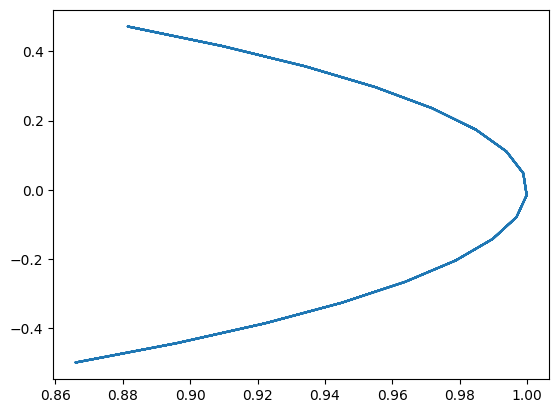

In [34]:
angle_tmp = angle_v(sigma_paths[0])
rho_tmp = rho_v(sigma_paths[0])
plt.plot(rho_tmp*np.cos(angle_tmp), rho_tmp*np.sin(angle_tmp))

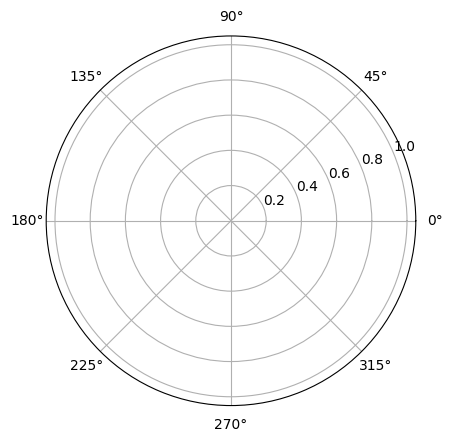

In [35]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
index = 0
ax.plot(angle_results[index], rho_results[index], '.')
index = 1
ax.plot(angle_results[index], rho_results[index], '.')
index = 2
ax.plot(angle_results[index], rho_results[index], '.')

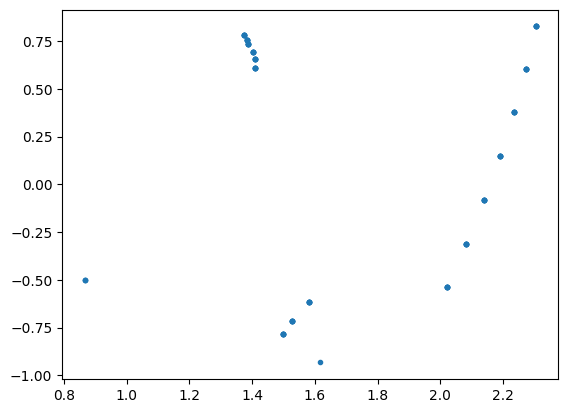

In [50]:
plt.plot(rho_results[index] * np.cos(angle_results[index]), rho_results[index] * np.sin(angle_results[index]), '.')

The `return_mapping` function returns a tuple with two elements. The first
element is an array containing values of the external operator
$\boldsymbol{\sigma}$ and the second one is another tuple containing
additional data such as e.g. information on a convergence of the Newton
method. Once we apply the JAX AD tool, the latter "converts" the first
element of the `return_mapping` output into an array with values of the
derivative
$\frac{\mathrm{d}\boldsymbol{\sigma}}{\mathrm{d}\boldsymbol{\varepsilon}}$
and leaves untouched the second one. That is why we return `sigma_local`
twice in the `return_mapping`: ....

COMMENT: Well, looks too wordy...
JSH eg.
`jax.jacfwd` returns a callable that returns the Jacobian as its first return
argument. As we also need sigma_local, we also return sigma_local as
auxilliary data.


NOTE: If we implemented the function `dsigma_ddeps` manually, it would return
`C_tang_local, (sigma_local, niter_total, yielding, norm_res)`

Once we defined the function `dsigma_ddeps`, which evaluates both the
external operator and its derivative locally, we can just vectorize it and
define the final implementation of the external operator derivative.

In [ ]:
dsigma_ddeps = jax.jacfwd(sigma_return_mapping, has_aux=True)
dsigma_ddeps_vec = jax.jit(jax.vmap(dsigma_ddeps, in_axes=(0, 0)))


def C_tang_impl(deps):
    deps_ = deps.reshape((-1, 4))
    sigma_n_ = sigma_n.x.array.reshape((-1, 4))

    (C_tang_global, state) = dsigma_ddeps_vec(deps_, sigma_n_)
    sigma_global, niter, yielding, norm_res = state

    unique_iters, counts = jnp.unique(niter, return_counts=True)

    # NOTE: The following code prints some details about the second Newton
    # solver, solving the constitutive equations. Do we need this or it's better
    # to have the code as clean as possible?

    print("\tInner Newton iteration summary")
    print(f"\t\tUnique number of iterations: {unique_iters}")
    print(f"\t\tCounts of unique number of iterations: {counts}")
    print(f"\t\tMaximum F: {jnp.max(yielding)}")
    print(f"\t\tMaximum residual: {jnp.max(norm_res)}")

    return C_tang_global.reshape(-1), sigma_global.reshape(-1)

Similarly to the von Mises example, we do not implement explicitly the
evaluation of the external operator. Instead, we obtain its values during the
evaluation of its derivative and then update the values of the operator in the
main Newton loop.

In [ ]:
def sigma_external(derivatives):
    if derivatives == (1,):
        return C_tang_impl
    else:
        return NotImplementedError


sigma.external_function = sigma_external

### Defining the forms

In [ ]:
n = ufl.FacetNormal(mesh)
P_o = fem.Constant(mesh, PETSc.ScalarType(0.0))
P_i = fem.Constant(mesh, PETSc.ScalarType(0.0))


# JSH: P_o is never set to anything but zero?
def F_ext(v):
    return -P_i * ufl.inner(n, v) * ds(facet_tags_labels["inner"]) + P_o * ufl.inner(n, v) * ds(
        facet_tags_labels["outer"]
    )


u_hat = ufl.TrialFunction(V)
F = ufl.inner(epsilon(u_), sigma) * dx - F_ext(u_)
J = ufl.derivative(F, Du, u_hat)
J_expanded = ufl.algorithms.expand_derivatives(J)

F_replaced, F_external_operators = replace_external_operators(F)
J_replaced, J_external_operators = replace_external_operators(J_expanded)

F_form = fem.form(F_replaced)
J_form = fem.form(J_replaced)

### Variables initialization and compilation
Before solving the problem it is required.

In [ ]:
# Initialize variables to start the algorithm
# NOTE: Actually we need to evaluate operators before the Newton solver
# in order to assemble the matrix, where we expect elastic stiffness matrix
# Shell we discuss it? The same states for the von Mises.
Du.x.array[:] = 1.0  # still the elastic flow

timer1 = common.Timer("1st JAX pass")
timer1.start()

evaluated_operands = evaluate_operands(F_external_operators)
((_, _),) = evaluate_external_operators(J_external_operators, evaluated_operands)

timer1.stop()

timer2 = common.Timer("2nd JAX pass")
timer2.start()

evaluated_operands = evaluate_operands(F_external_operators)
((_, _),) = evaluate_external_operators(J_external_operators, evaluated_operands)

timer2.stop()

timer3 = common.Timer("3rd JAX pass")
timer3.start()

evaluated_operands = evaluate_operands(F_external_operators)
((_, _),) = evaluate_external_operators(J_external_operators, evaluated_operands)

timer3.stop()

In [ ]:
# TODO: Is there a more elegant way to extract the data?
# TODO: Maybe we analyze the compilation time in-place?
common.list_timings(MPI.COMM_WORLD, [common.TimingType.wall])

### Solving the problem

Summing up, we apply the Newton method to solve the main weak problem. On each
iteration of the main Newton loop, we solve elastoplastic constitutive equations
by using the second Newton method at each Gauss point. Thanks to the framework
and the JAX library, the final interface is general enough to be reused for
other plasticity models.

In [ ]:
external_operator_problem = LinearProblem(J_replaced, -F_replaced, Du, bcs=bcs)

In [ ]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u It
# is required to run this program via MPI in order to capture the process, to
# which this point is attached
x_point = np.array([[R_i, 0, 0]])
cells, points_on_process = find_cell_by_point(mesh, x_point)

In [ ]:
# parameters of the manual Newton method
max_iterations, relative_tolerance = 200, 1e-8
num_increments = 20
load_steps = np.linspace(0.9, 5, num_increments, endpoint=True)[1:]
results = np.zeros((num_increments, 2))

for i, load in enumerate(load_steps):
    P_i.value = load
    external_operator_problem.assemble_vector()

    residual_0 = external_operator_problem.b.norm()
    residual = residual_0
    Du.x.array[:] = 0

    if MPI.COMM_WORLD.rank == 0:
        print(f"Load increment: {i}, load: {load}, initial residual: {residual_0}")

    for iteration in range(0, max_iterations):
        if residual / residual_0 < relative_tolerance:
            break

        if MPI.COMM_WORLD.rank == 0:
            print(f"\tOuter Newton iteration {iteration}")
        external_operator_problem.assemble_matrix()
        external_operator_problem.solve(du)

        Du.vector.axpy(1.0, du.vector)
        Du.x.scatter_forward()

        evaluated_operands = evaluate_operands(F_external_operators)
        ((_, sigma_new),) = evaluate_external_operators(J_external_operators, evaluated_operands)
        sigma.ref_coefficient.x.array[:] = sigma_new

        external_operator_problem.assemble_vector()
        residual = external_operator_problem.b.norm()

        if MPI.COMM_WORLD.rank == 0:
            print(f"\tResidual: {residual}\n")

    u.vector.axpy(1.0, Du.vector)
    u.x.scatter_forward()

    sigma_n.x.array[:] = sigma.ref_coefficient.x.array

    if len(points_on_process) > 0:
        results[i + 1, :] = (u.eval(points_on_process, cells)[0], load)

### Post-processing

In [ ]:
if len(points_on_process) > 0:
    plt.plot(results[:, 0], results[:, 1], "-o", label="via ExternalOperator")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.legend()
    plt.show()

In [ ]:
# TODO: Is there a more elegant way to extract the data?
# common.list_timings(MPI.COMM_WORLD, [common.TimingType.wall])

In [ ]:
# # NOTE: There is the warning `[WARNING] yaksa: N leaked handle pool objects`
# for # the call `.assemble_vector()` and `.vector`. # NOTE: The following
# lines eleminate the leakes (except the mesh ones). # NOTE: To test this for
# the newest version of the DOLFINx.
external_operator_problem.__del__()
Du.vector.destroy()
du.vector.destroy()
u.vector.destroy()